# Importation des bibliothèques

In [1]:
import numpy as np
import sympy as sm
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import dblquad

### Parametres

In [2]:
x_p = 2.86575
x_E1 = 1.32
x_E2 = 4.06
y_0 = 0
dev_P = 1
n_crossbars_real = 7 #impair
gap_crossbars = 0.48 #m

Tol_graph_1 = 0.2
Tol_graph_2 = 1.5
Tol_graph_3_gau = 4
Tol_graph_3_dro = 1.5

### Fonctions importantes

In [ ]:
def Parabole_y_n(x,m_p,C_p):
    P = m_p*x**2 + C_p
    return P

def Ligne_droite(x,m_g,C_g):
    G = m_g*x + C_g
    return G

def Calcul_parabole(x_p, dev_P, y_0):
    m_p = dev_P/(2*x_p)
    C_p = y_0
    Parametres_parabole = np.array([m_p, C_p])
    return Parametres_parabole 

def Calcul_ligne_droite(x_E1, x_E2, Parametres_parabole):
    y_E1 = Parabole_y_n(x_E1, Parametres_parabole[0], Parametres_parabole[1]) 
    y_E2 = Parabole_y_n(x_E2, Parametres_parabole[0], Parametres_parabole[1])
    
    m_g = (y_E2 - y_E1)/(x_E2 - x_E1) #41° - 44.9°
    C_g = y_E1-m_g*x_E1
    Parametres_ligne = np.array([m_g, C_g])
    return Parametres_ligne

def Calcul_parameters_ellipse(Parametres_parabole, Parametres_ligne):
    a = np.sqrt((Parametres_ligne[0]/(2*Parametres_parabole[0]))**2 - (Parametres_parabole[1]-Parametres_ligne[1])/Parametres_parabole[0])
    ratio_angle = np.arctan(Parametres_ligne[1])
    ratio_ellipse = np.cos(ratio_angle)
    b = a/ratio_ellipse
    h = ((b-a)/(b+a))**2
    perimetre = np.pi*(a+b)*(1 + (3*h)/(10 + np.sqrt(4-3*h)))
    Parametres_ellipse = np.array([a, b, ratio_ellipse, perimetre])
    return Parametres_ellipse

def Distribution_crossbars(Parametres_ellipse, n_crossbars_real, gap_crossbars, Parametres_ligne, Parametres_parabole, x_E1, x_E2):
    if n_crossbars_real%2 == 0:
        print("Le nombre de barres transversales est incorrect")
    else:
        x_lim = gap_crossbars*(n_crossbars_real-1)/2.
        if x_lim > Parametres_ellipse[1]:
            x_lim = Parametres_ellipse[1]
            print("L'espacement entre les barres est incorrect")
            x_n = np.linspace(-x_lim, x_lim, n_crossbars_real+2) 
        else:
            x_n = np.linspace(-x_lim, x_lim, n_crossbars_real)    
            x_n = np.concatenate(([-Parametres_ellipse[1]], x_n, [Parametres_ellipse[1]]))
        
    y_n = Parametres_ellipse[2]*np.sqrt((Parametres_ellipse[1]**2 - x_n**2))
    
    perpendicular_angle = np.arctan(Parametres_ligne[0]) - (np.pi/2)
    m_q_n = np.tan(perpendicular_angle)
    x_q_n_middle = (x_E2 + x_E1)/2
    y_q_n_middle = Ligne_droite(x_q_n_middle, Parametres_ligne[0], Parametres_ligne[1]) 
    C_q_n_middle = y_q_n_middle - x_q_n_middle*m_q_n
    ratio_ellipse_qn = np.cos(abs(perpendicular_angle))
    
    coefficients_quad = np.array([Parametres_parabole[0], (-m_q_n), (Parametres_parabole[1] - C_q_n_middle)])
    roots = np.roots(coefficients_quad)
    real_roots = roots[np.isreal(roots)].real
    x_intersect = real_roots[real_roots>=0][0]
    
    y_intersect = Parabole_y_n(x_intersect, Parametres_parabole[0], Parametres_parabole[1]) 
    
    
    C_q_vec = np.zeros(n_crossbars_real)
    a_qn_vec = np.zeros(n_crossbars_real)
    b_qn_vec = np.zeros(n_crossbars_real)
    
    i_middle = int((n_crossbars_real+1)/2)
    
    for i in range(n_crossbars_real):
        C_q_vec[i] = (x_n[i+1] - x_n[i_middle])/np.cos(abs(perpendicular_angle)) + C_q_n_middle
        a_qn_vec[i] = np.sqrt( ((m_q_n)/(2*Parametres_parabole[0]))**2 - (Parametres_parabole[1] - C_q_vec[i])/Parametres_parabole[0] )
        b_qn_vec[i] = a_qn_vec[i]/ratio_ellipse_qn
    return x_n, y_n, m_q_n, C_q_vec, a_qn_vec, b_qn_vec, perpendicular_angle, x_intersect, y_intersect


def Crossbars_information(n_crossbars_real, y_n, a_qn_vec, perpendicular_angle):
    delta_n = np.zeros(n_crossbars_real)
    R_n = np.zeros(n_crossbars_real)
    beta_n = np.zeros(n_crossbars_real)
    arc_n = np.zeros(n_crossbars_real)
    
    for i in range(n_crossbars_real):
        delta_n[i] = (a_qn_vec[i] - np.sqrt( a_qn_vec[i]**2 - y_n[i+1]**2 ) )/np.cos(perpendicular_angle)
        R_n[i] = (delta_n[i]**2 + y_n[i+1]**2)/(2*delta_n[i])
        beta_n[i] = np.arcsin(y_n[i+1]/R_n[i])
        arc_n[i] = 2*R_n[i]*(beta_n[i])    
    
    return delta_n, R_n, beta_n, arc_n


def alpha_solar(n_year):
    principal_angle = (n_year-1)*(2*np.pi)/(365)
    alpha_rad = 0.006918 - 0.399912*np.cos(principal_angle) + 0.070257*np.sin(principal_angle) - 0.006758*np.cos(2*principal_angle) + 0.000907*np.sin(2*principal_angle) -0.002769*np.cos(3*principal_angle) + 0.00148*np.sin(3*principal_angle) 
    alpha_deg = (180/np.pi)*(alpha_rad)
    return alpha_rad


def determine_rotation(x_parabola, y_parabola, alpha, f_point_x, f_point_y):
    x_parabola_tr = x_parabola - f_point_x
    y_parabola_tr = y_parabola - f_point_y
    Matrix = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]])
    
    coordinates = np.array([x_parabola_tr, y_parabola_tr])
    new_coordinates = np.dot(coordinates, Matrix)
    x_parabola_new = new_coordinates[0] + f_point_x
    y_parabola_new = new_coordinates[1] + f_point_y
        
    return x_parabola_new, y_parabola_new
    
    
def Paraboloide_rev(x,y,Parametres_parabole):
    f = Parametres_parabole[0]*(x**2+y**2) + Parametres_parabole[1]
    return f

def dev_Paraboloide_rev_x(x,y,Parametres_parabole):
    dz_dx = 2*Parametres_parabole[0]*x
    return dz_dx

def dev_Paraboloide_rev_y(x,y,Parametres_parabole):
    dz_dy = 2*Parametres_parabole[0]*y
    return dz_dy

def valeur_surface(Parametres_parabole, a_cercle, r_cercle, n_x, n_y):
    delta_x = (2*r_cercle)/(n_x-1)
    delta_y = (2*r_cercle)/(n_y-1)
    dA = delta_x*delta_y
    
    sum_int = 0
    
    for j in range(n_x-1):
        for i in range(n_y-1):
            x_j = a_cercle - r_cercle + (j)*delta_x/2 + delta_x/2
            y_i = r_cercle - (i)*delta_y/2 - delta_y/2
            
            if (x_j - a_cercle)**2 + y_i**2 <= r_cercle**2:
                sum_int = sum_int + dA*np.sqrt(1 + dev_Paraboloide_rev_x(x_j,y_i,Parametres_parabole)**2 + dev_Paraboloide_rev_y(x_j,y_i,Parametres_parabole)**2)
            
    return sum_int

def integrate_line(a, b, f, n):
    if a > b:
        a, b = b, a
    h = (b - a) / n
    total = 0
    for i in range(n):
        x = a + (i + 0.5) * h
        total += np.sqrt(1 + (x/(2*f))**2)
    return total * h


def valeur_torque(Parametres_parabole, x_E1, x_E2):
    # Compute the value of f [(x-h)^2 = 4*p*(y-k)] Vertice (h,k) Foco (h,k+p)
    k = Parametres_parabole[1]
    f = 1/(4*Parametres_parabole[0])
    n = 1000
    int_val_gau_orig = integrate_line(x_E1, 2*f, f, n)
    int_val_droi_orig = integrate_line(2*f, x_E2, f, n)
    
    def objective(yy):
        int_val_gau = integrate_line(x_E1, 2*f, f, n)
        int_val_droi = integrate_line(2*f, yy, f, n)
        return int_val_gau - int_val_droi
    
    
    x_E2_min = 2*f  # valor mínimo para x_E2
    x_E2_max = 10*f  # valor máximo para x_E2
    tol = 1e-5
    
    while (x_E2_max - x_E2_min) > tol:
        x_E2_mid = (x_E2_min + x_E2_max) / 2
        if objective(x_E2_mid) > 0:
            x_E2_min = x_E2_mid
        else:
            x_E2_max = x_E2_mid
    
    x_E2_opt = (x_E2_min + x_E2_max) / 2
    int_val_droi_opt = integrate_line(2*f, x_E2_opt, f, n)
    
    
    return int_val_gau_orig, int_val_droi_orig, x_E2_opt, int_val_droi_opt
    

### 1 Partie - Calcul des points de la parabole et ligne droite (cut plane)

Equation 1: $$ P^{'}(x) = 2 m_p x_P = 1 \quad \longrightarrow \quad m_p = \frac{1}{2x_P} $$

Equation 2: $$ C_p = y_0 $$

Equation 3: $$ m_g = \frac{y_{E2}-y_{E1}}{x_{E2}-x_{E1}} $$

Equation 4: $$ C_g = y_{E1} - m_g x_{E1} $$

L'équation de la parabole est : y = 0.17447·x² + 0.00000
L'équation de la droite du plan de coupe de l'ellipse de projection est : y = 0.93867·x + -0.93504
La valeur du foyer est : (0.0, 1.43287)


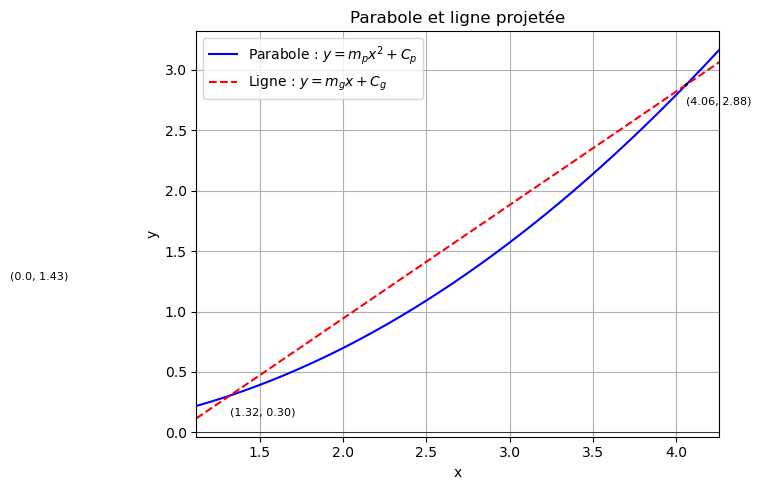

In [4]:

Parametres_parabole = Calcul_parabole(x_p, dev_P, y_0)
Parametres_ligne = Calcul_ligne_droite(x_E1, x_E2, Parametres_parabole)

print(f"L'équation de la parabole est : y = {Parametres_parabole[0]:.5f}·x² + {Parametres_parabole[1]:.5f}")
print(f"L'équation de la droite du plan de coupe de l'ellipse de projection est : y = {Parametres_ligne[0]:.5f}·x + {Parametres_ligne[1]:.5f}")

# Compute the focus
f_point_x = 0.0
f_point_y = 1./(4*Parametres_parabole[0])

print(f"La valeur du foyer est : ({f_point_x}, {f_point_y:.5f})")

#Graph
x_graph = np.linspace(x_E1-Tol_graph_1, x_E2+Tol_graph_1, 400)
y_parabole = Parabole_y_n(x_graph, Parametres_parabole[0], Parametres_parabole[1])
y_ligne = Ligne_droite(x_graph, Parametres_ligne[0], Parametres_ligne[1])

y_E1 = Parabole_y_n(x_E1, Parametres_parabole[0], Parametres_parabole[1]) 
y_E2 = Parabole_y_n(x_E2, Parametres_parabole[0], Parametres_parabole[1])
plt.figure(figsize=(8, 5))
plt.plot(x_graph, y_parabole, label="Parabole : $y = m_p x^2 + C_p$", color="blue")
plt.plot(x_graph, y_ligne, label="Ligne : $y = m_g x + C_g$", color="red", linestyle="--")
plt.scatter([x_E1, x_E2], [y_E1, y_E2], [f_point_x, f_point_y], color='black', zorder=5)
plt.text(x_E1, y_E1 - 0.1, f"({x_E1}, {y_E1:.2f})", verticalalignment='top', fontsize=8)
plt.text(x_E2, y_E2 - 0.1, f"({x_E2}, {y_E2:.2f})", verticalalignment='top', fontsize=8)
plt.text(f_point_x, f_point_y - 0.1, f"({f_point_x}, {f_point_y:.2f})", verticalalignment='top', fontsize=8)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Parabole et ligne projetée")
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(x_E1-Tol_graph_1, x_E2+Tol_graph_1)
plt.tight_layout()
plt.show()

### 2 Partie - Calculer les parametres de l'ellipse et ses crossbars

Equation 1 : $$ a = \sqrt{\left( \frac{m_g}{2 m_p} \right)^2 - \frac{C_p - C_g}{m_p}} $$

Equation 2 : $$ \text{Ratio\_angle} = \text{arctan}\left( m_g \right) $$

Equation 3 : $$ \text{Ratio\_ellipse} = \text{cos}\left( \text{Ratio\_angle} \right) = \frac{a}{b} $$

Equation 4 : $$  b = \frac{a}{\text{Ratio\_ellipse}} $$

Equation 5 (Distribution of crossbars) : $$ y_n = \text{Ratio\_ellipse} \cdot \sqrt{b^2 - x_n^2}  $$

Equation 6 (Perpendicular slope for cutting planes that creates the crossbars): $$ m_{qn} = \bar{m}_q = \text{tan}\left( \frac{\pi}{2} - \text{Ratio\_angle} \right) $$

Equation 7 (Intersection point for the middle point) : $$ x_{q, \text{n\_middle}} = \frac{x_{E2}-x_{E1}}{2}  $$

Equation 8 (Calculus of the intersect value of the line equation) : $$ C_{q, \text{n\_middle}} = m_p \cdot x_{q, \text{n\_middle}}^2 + C_p  $$

Equation 9 (Calculus of the rest of cutplanes for crossbars) : $$ \text{y\_Difference} = \Delta x_{\text{Ellipse}} \cdot \cos \left( \left|  \frac{\pi}{2} - \text{Ratio\_angle}  \right| \right)  $$

Crossbar information
       n      x_n      y_n      m_q_n      C_q_n       a_qn       b_qn
------------------------------------------------------------
       1   -1.440    0.878     -1.065      2.352      4.775      6.977
       2   -0.960    1.177     -1.065      3.053      5.179      7.567
       3   -0.480    1.324     -1.065      3.754      5.553      8.114
       4    0.000    1.370     -1.065      4.456      5.904      8.627
       5    0.480    1.324     -1.065      5.157      6.235      9.111
       6    0.960    1.177     -1.065      5.858      6.550      9.570
       7    1.440    0.878     -1.065      6.560      6.850     10.008


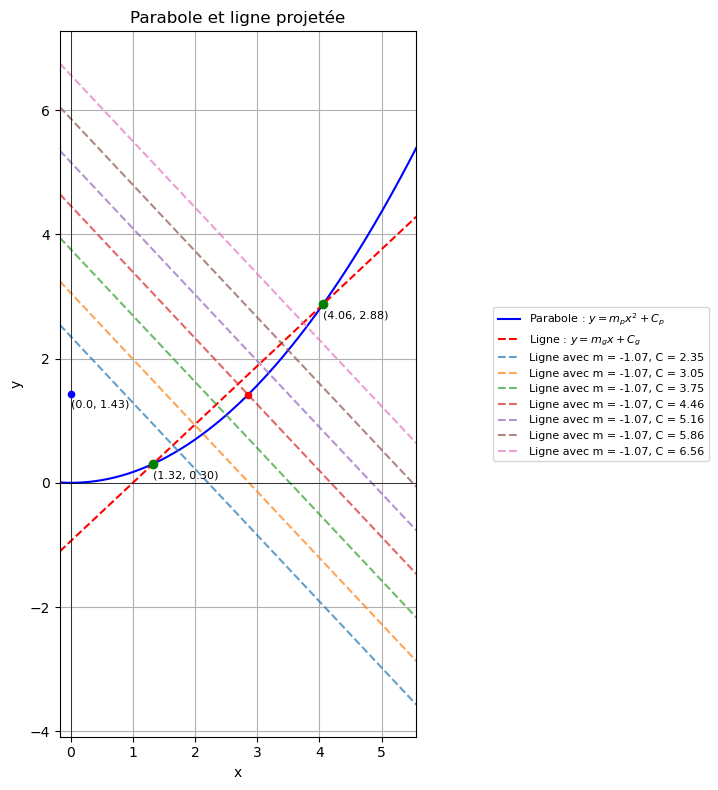

In [5]:

Parametres_ellipse = Calcul_parameters_ellipse(Parametres_parabole, Parametres_ligne)
x_n, y_n, m_q_n, C_q_vec, a_qn_vec, b_qn_vec, perpendicular_angle, x_intersect, y_intersect = Distribution_crossbars(Parametres_ellipse, n_crossbars_real, gap_crossbars, Parametres_ligne, Parametres_parabole, x_E1, x_E2)

print("Crossbar information")
print(f"{'n':>8} {'x_n':>8} {'y_n':>8} {'m_q_n':>10} {'C_q_n':>10} {'a_qn':>10} {'b_qn':>10}")
print("-" * 60)
for i in range(len(C_q_vec)):
    print(f"{i+1:8} {x_n[i+1]:8.3f} {y_n[i+1]:8.3f} {m_q_n:10.3f} {C_q_vec[i]:10.3f} {a_qn_vec[i]:10.3f} {b_qn_vec[i]:10.3f}")
    

#Graph
x_graph = np.linspace(x_E1-Tol_graph_2, x_E2+Tol_graph_2, 400)
y_parabole = Parabole_y_n(x_graph, Parametres_parabole[0], Parametres_parabole[1])
y_ligne = Ligne_droite(x_graph, Parametres_ligne[0], Parametres_ligne[1])

y_E1 = Parabole_y_n(x_E1, Parametres_parabole[0], Parametres_parabole[1]) 
y_E2 = Parabole_y_n(x_E2, Parametres_parabole[0], Parametres_parabole[1])
plt.figure(figsize=(14, 8))
plt.plot(x_graph, y_parabole, label="Parabole : $y = m_p x^2 + C_p$", color="blue")
plt.plot(x_graph, y_ligne, label="Ligne : $y = m_g x + C_g$", color="red", linestyle="--")
plt.scatter(x_intersect, y_intersect, color='red', s=20, zorder=10)
plt.scatter(f_point_x, f_point_y, color='blue', s=20, zorder=10)
plt.scatter([x_E1, x_E2], [y_E1, y_E2], color='green', zorder=8)
plt.text(x_E1, y_E1 - 0.1, f"({x_E1}, {y_E1:.2f})", verticalalignment='top', fontsize=8)
plt.text(x_E2, y_E2 - 0.1, f"({x_E2}, {y_E2:.2f})", verticalalignment='top', fontsize=8)
plt.text(f_point_x, f_point_y - 0.1, f"({f_point_x}, {f_point_y:.2f})", verticalalignment='top', fontsize=8)
for i in range(len(C_q_vec)):
    y_ligne_q = (m_q_n) * x_graph + C_q_vec[i]
    plt.plot(x_graph, y_ligne_q, label=f"Ligne avec m = {m_q_n:.2f}, C = {C_q_vec[i]:.2f}", linestyle="--", alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Parabole et ligne projetée")
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(x_E1-Tol_graph_2, x_E2+Tol_graph_2)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', fontsize=8)
plt.tight_layout()
plt.show()


### Partie 3 - Calculation of depths and arc lengths for the crossbars

Equation 1 : $$ \Delta_n = \left[  a_{qn} - \sqrt{a_{qn}^{2} - Y_n^2} \right] / \text{cos}\left( \text{perp\_angle} \right) $$

Equation 2 : $$ R_n = \frac{\Delta_n^2 + Y_n^2}{2 \Delta_n}  $$

Equation 3 : $$ \beta_n = \text{sin}^{-1} \left( \frac{Y_n}{R_n} \right) $$

Equation 4 : $$ b_n = 2 R_n \left( \frac{2 \pi \beta_n}{360}  \right)  $$

![alt text](image.png)

In [6]:
delta_n, R_n, beta_n, arc_n = Crossbars_information(n_crossbars_real, y_n, a_qn_vec, perpendicular_angle)

print("Crossbar geometrical information")
print(f"{'n':>8} {'y_n':>8} {'delta_n':>8} {'R_n':>8} {'beta_n':>10} {'arc_n':>10}")
print("-" * 60)
for i in range(len(C_q_vec)):
    print(f"{i+1:8}  {y_n[i+1]:8.3f} {delta_n[i]:8.3f} {R_n[i]:10.3f} {(180/np.pi)*beta_n[i]:10.3f} {arc_n[i]:10.3f}")

print("\n")
print(f"La longueur du contour extérieur de l’ellipse est égale à : {Parametres_ellipse[3]:.4f}")



Crossbar geometrical information
       n      y_n  delta_n      R_n     beta_n      arc_n
------------------------------------------------------------
       1     0.878    0.119      3.300     15.429      1.777
       2     1.177    0.198      3.597     19.099      2.398
       3     1.324    0.234      3.863     20.050      2.704
       4     1.370    0.235      4.103     19.504      2.794
       5     1.324    0.208      4.323     17.841      2.692
       6     1.177    0.156      4.524     15.079      2.381
       7     0.878    0.083      4.710     10.742      1.766


La longueur du contour extérieur de l’ellipse est égale à : 10.2583


### Partie 4 - Seasonal parabola equations

Equation 1 : $$ \text{Normal\_angle} = \text{arctan} \left( m_p \right) $$

Equation 2 : $$ {P^{\text{new}}}^{'}(x) = \text{arctan} \left( \text{Normal\_angle} + \alpha \right) $$

Equaion 3 : $$ \alpha = f(n_{\text{year}}) $$

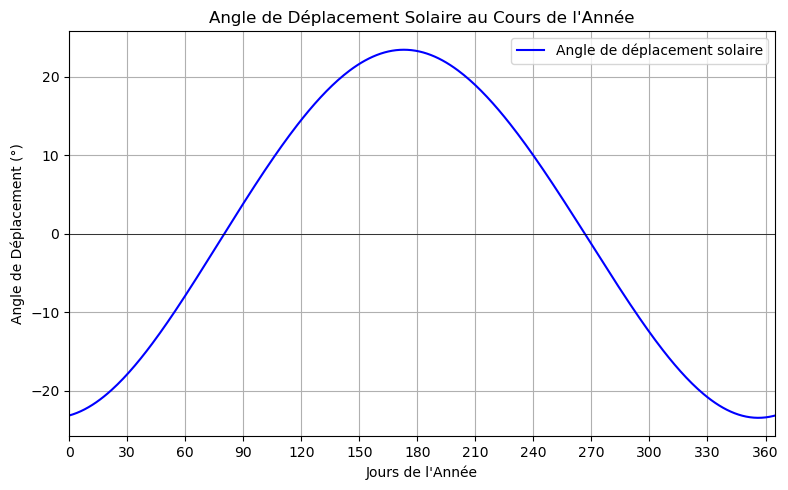

L'équation de la parabole pour l'été est : y = 0.28907·x² + 0.56803
L'équation de la parabole pour l'hiver est : y = 0.12506·x² + -0.56610


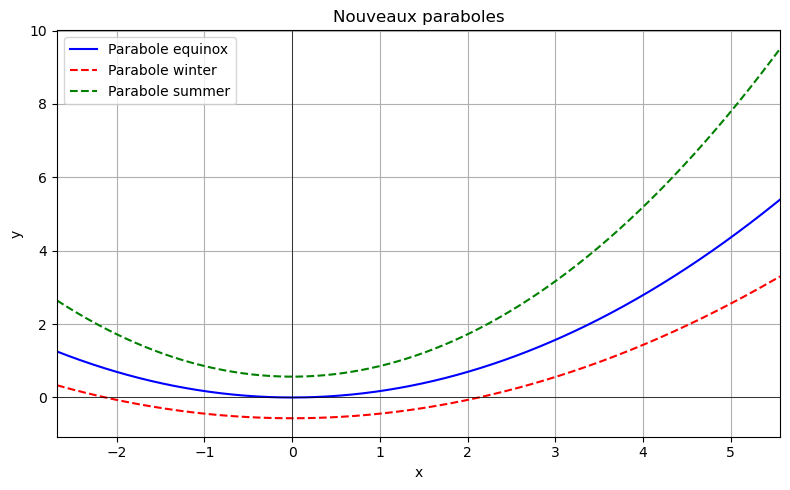

In [7]:
# Graph of the solar angle through the year
days_year = np.linspace(0,365,366)
alpha_year = (180/np.pi)*alpha_solar(days_year)

plt.figure(figsize=(8, 5))
plt.plot(days_year, alpha_year, label="Angle de déplacement solaire", color="blue")
plt.title("Angle de Déplacement Solaire au Cours de l'Année")
plt.xlabel("Jours de l'Année")
plt.ylabel("Angle de Déplacement (°)")
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(0, 365)
plt.xticks(np.arange(0, 366, 30))  # Marquer les mois
plt.legend()
plt.tight_layout()
plt.show()



# Compute the parabola for winter and summer
n_winter = 355 #172 -> June 21 (Summer) / #355 -> December 21 (Winter)
alpha_winter = alpha_solar(n_winter)
x_parabole_winter, y_parabole_winter = determine_rotation(x_intersect, y_intersect, alpha_winter, f_point_x, f_point_y)
m_w = np.tan(np.arctan(2*Parametres_parabole[0]*x_intersect) + alpha_winter/2)/(2*x_parabole_winter)
C_w = y_parabole_winter - m_w*x_parabole_winter**2

n_summer = 172 #172 -> June 21 (Summer) / #355 -> December 21 (Winter)
alpha_summer = alpha_solar(n_summer)
x_parabole_summer, y_parabole_summer = determine_rotation(x_intersect, y_intersect, alpha_summer, f_point_x, f_point_y)
m_s = np.tan(np.arctan(2*Parametres_parabole[0]*x_intersect) + alpha_summer/2)/(2*x_parabole_summer)
C_s = y_parabole_summer - m_s*x_parabole_summer**2


x_parabole_norm = np.linspace(x_E1-Tol_graph_3_gau, x_E2+Tol_graph_3_dro, 800)
y_parabole_norm_graph = Parabole_y_n(x_parabole_norm, Parametres_parabole[0], Parametres_parabole[1])
y_parabole_winter_graph = Parabole_y_n(x_parabole_norm, m_w, C_w)
y_parabole_summer_graph = Parabole_y_n(x_parabole_norm, m_s, C_s)

print(f"L'équation de la parabole pour l'été est : y = {m_s:.5f}·x² + {C_s:.5f}")
print(f"L'équation de la parabole pour l'hiver est : y = {m_w:.5f}·x² + {C_w:.5f}")


plt.figure(figsize=(8, 5))
plt.plot(x_parabole_norm, y_parabole_norm_graph, label="Parabole equinox", color="blue")
plt.plot(x_parabole_norm, y_parabole_winter_graph, label="Parabole winter", color="red", linestyle="--")
plt.plot(x_parabole_norm, y_parabole_summer_graph, label="Parabole summer", color="green", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nouveaux paraboles")
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(x_E1-Tol_graph_3_gau, x_E2+Tol_graph_3_dro)
plt.tight_layout()
plt.show()

### Partie 5 - Vérifier le valeur de la surface

Equation 1 : $$ A = \int \int_S \sqrt{1 + \left( \frac{\partial z}{\partial x} \right)^2 + \left( \frac{\partial z}{\partial y} \right)^2} \ \text{d}A$$

Equation 2 : $$ \frac{\partial z}{\partial x}  = 2 m_p \cdot x $$

Equation 3 : $$ \frac{\partial z}{\partial y}  = 2 m_p \cdot y $$

In [8]:
r_cercle = Parametres_ellipse[0]
a_cercle = x_E1 + r_cercle

# Calcul de la surface
surface = valeur_surface(Parametres_parabole, a_cercle, r_cercle, 1000, 1000)
print(f"Surface du paraboloïde: {surface:.4f}")

# Calcul stabilité
valeur_gau, valeur_droi, x_E2_opt, int_val_droi_opt = valeur_torque(Parametres_parabole, x_E1, x_E2)
print(f"Valeur de l'intégrale de ligne par le côté gauche {valeur_gau:.4f}")
print(f"Valeur de l'intégrale de ligne par le côté droite {valeur_droi:.4f}")
print(f"Valeur x_E2 optimal {x_E2_opt:.4f}")
print(f"Valeur de l'intégrale de ligne par le côté droite optimale {int_val_droi_opt:.4f}")

Surface du paraboloïde: 7.4860
Valeur de l'intégrale de ligne par le côté gauche 1.9240
Valeur de l'intégrale de ligne par le côté droite 1.8754
Valeur x_E2 optimal 4.0880
Valeur de l'intégrale de ligne par le côté droite optimale 1.9240
